# Ecommerce RFM Segmentation Analysis

---

### Data Preprocessing

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# read and concatenate datasets
df1=pd.read_csv('dataset/archive/2019-Oct.csv')
df2=pd.read_csv('dataset/archive/2019-Nov.csv')
df3=pd.read_csv('dataset/archive/2019-Dec.csv')
df4=pd.read_csv('dataset/archive/2020-Jan.csv')
df5=pd.read_csv('dataset/archive/2020-Feb.csv')

df=pd.concat([df1,df2,df3,df4,df5], axis=0, ignore_index=True)

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [4]:
df.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
20692835,2020-02-29 23:59:32 UTC,view,5885416,1487580005092295511,NaN,grattol,6.27,622082947,fb29909b-6ef5-4662-b4ee-288e73e5dc10
20692836,2020-02-29 23:59:39 UTC,cart,5550686,1487580008145748965,NaN,NaN,1.11,459705611,05d2add3-01f7-47ee-8364-27341673227f
20692837,2020-02-29 23:59:45 UTC,view,5850628,1602943681873052386,NaN,grattol,5.24,622090043,ab7d349f-db5d-4790-8ab1-31e5c894459d
20692838,2020-02-29 23:59:54 UTC,view,5716351,1487580010872045658,NaN,irisk,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d
20692839,2020-02-29 23:59:59 UTC,view,5927709,1487580013950664926,NaN,de.lux,3.17,621669991,daa3c677-5360-4327-847e-d29658716b99


**Assumption**: Since there is no 'quantity' column, we assume that duplicated records indicate multiple occurrences of the same event with varying quantities of the product. In this case, we are not dropping duplicates.

In [5]:
df.shape

(20692840, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


In [7]:
# convert 'event_time' to DateTime format
df['event_time'] = pd.to_datetime(df['event_time'].str.strip(to_strip=' UTC'), infer_datetime_format=True)

In [8]:
df['month'] = df.event_time.dt.month.map({10:'Oct',11:'Nov',12:'Dec',1:'Jan',2:'Feb'})

In [9]:
# check NA values
na_count = df.isna().sum()
na_proportion = df.isna().sum()/len(df)
pd.DataFrame({'NA Count': na_count, 'NA Proportion': na_proportion})

,NA Count,NA Proportion
event_time,0,0.000000
event_type,0,0.000000
product_id,0,0.000000
category_id,0,0.000000
category_code,20339246,0.982912
brand,8757117,0.423196
price,0,0.000000
user_id,0,0.000000
user_session,4598,0.000222
month,0,0.000000


In [10]:
# since the main focus of the project is customer segmentation, we will be dropping some irrelevant columns
df = df.drop(columns=['product_id', 'category_id', 'category_code', 'brand'])

In [11]:
# numeric variable explore
df.price.describe()

count    2.069284e+07
mean     8.534735e+00
std      1.938142e+01
min     -7.937000e+01
25%      2.060000e+00
50%      4.050000e+00
75%      7.060000e+00
max      3.277800e+02
Name: price, dtype: float64

In [12]:
# check the negative values in 'price'
df[df.price < 0]

,event_time,event_type,price,user_id,user_session,month
112860,2019-10-01 19:10:56,purchase,-23.81,552507528,dcdd60c6-1a70-442d-bfb2-0252879054ad,Oct
198302,2019-10-02 08:30:03,purchase,-7.94,550375225,5ddec778-9464-4514-914d-be7b751b8e2c,Oct
436918,2019-10-03 17:37:04,purchase,-47.62,555414763,479149eb-1807-4178-8f6b-87c642350735,Oct
443204,2019-10-03 18:25:39,purchase,-15.87,556383221,4333d203-bc4d-4d0d-a6e1-0ea3a97a28c1,Oct
1295556,2019-10-09 14:49:14,purchase,-7.94,514562574,fed2aeb4-0c75-44f7-9ca8-1a8be8214779,Oct
...,...,...,...,...,...,...
20155317,2020-02-26 08:33:10,purchase,-23.81,561478621,30a1e1e8-2a48-4e3f-b7ff-1dbeb5d48541,Feb
20575128,2020-02-29 07:15:17,purchase,-7.94,435867669,4cdd7540-7a66-44de-9475-722ae3b4d615,Feb
20603815,2020-02-29 11:41:09,purchase,-47.62,621854037,99db4dd7-17ba-4645-9879-e035628711bf,Feb
20646154,2020-02-29 17:10:44,remove_from_cart,-23.81,621914288,bf16ca09-b11f-4c3c-a332-1bfdbb65d303,Feb


In [13]:
# Assuming that negative values correspond to the event type 'remove_from_cart', which has been proven incorrect
# we will convert all negative values to positive to avoid confusion.
df.loc[df.price < 0, 'price'] = df.loc[df.price < 0, 'price'].abs()

In [14]:
# variables unique values count
df.nunique()

event_time      8782890
event_type            4
price              2855
user_id         1639358
user_session    4535941
month                 5
dtype: int64

### E-commerce Performence Exploration

In [16]:
# creat a sub dataset in order to calculate sales easily
df_sales = df[df.event_type == 'purchase']

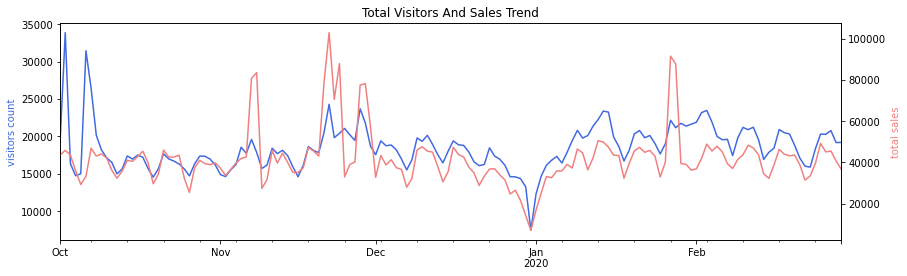

<Figure size 432x288 with 0 Axes>

In [17]:
# find out the traffic and sales trend
plt.style.use('seaborn-deep')

fig, ax1 = plt.subplots(figsize=(14, 4))

df.resample('D', on='event_time').user_id.nunique().plot(ax=ax1, color='royalblue')
ax1.set_xlabel('')
ax1.set_ylabel('visitors count', color='royalblue')

ax2 = ax1.twinx()
df_sales.resample('D', on='event_time').price.sum().plot(ax=ax2, color='lightcoral')
ax2.set_ylabel('total sales', color='lightcoral' )

ax1.set_title('Total Visitors And Sales Trend')
plt.show()

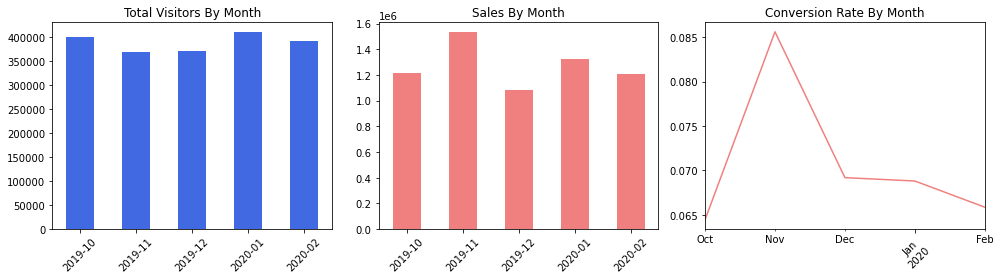

In [18]:
# find out the monthly traffic, sales and conversion rate
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
total_user=df.groupby(df.event_time.dt.to_period('M')).user_id.nunique()
total_user.plot(kind='bar', color='royalblue')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Total Visitors By Month')

plt.subplot(1,3,2)
monthly_sales=df_sales.groupby(df.event_time.dt.to_period('M')).price.sum()
monthly_sales.plot(kind='bar', color='lightcoral')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Sales By Month')

plt.subplot(1,3,3)
conver = df_sales.groupby(df.event_time.dt.to_period('M')).user_id.nunique()/total_user
conver.plot(color='lightcoral')
plt.xlabel('')
plt.xticks(rotation=45)
plt.title('Conversion Rate By Month')
plt.tight_layout()
plt.show()

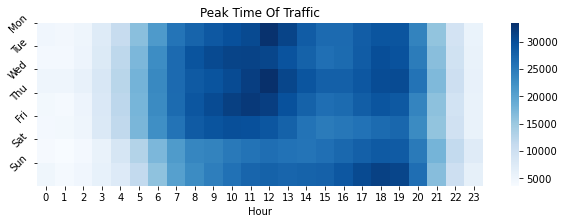

In [19]:
# find out the peak time of the traffic
plt.figure(figsize=(10,3))
table = df.pivot_table(index=df.event_time.dt.weekday, columns=df.event_time.dt.hour, values='user_id', aggfunc=pd.Series.nunique)
sns.heatmap(table, cmap='Blues')
y=[0,1,2,3,4,5,6]
labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.yticks(y, labels, rotation=45)
plt.xlabel('Hour')
plt.ylabel('')
plt.title('Peak Time Of Traffic')
plt.show()

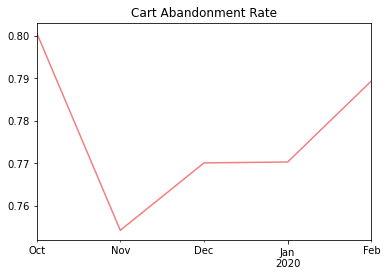

In [20]:
# calculate cart abandonment rate
purchase = df_sales.groupby(df.event_time.dt.to_period('M')).user_id.count()
cart = df[df.event_type == 'cart'].groupby(df.event_time.dt.to_period('M')).user_id.count()
ab = 1 -(purchase/cart)
ab.plot(color='lightcoral')
plt.xlabel('')
plt.title('Cart Abandonment Rate')
plt.show()

In [21]:
# calculate average order value
aov = round(df_sales.price.sum()/df_sales.user_session.nunique(),2)
print(f"The average order value is ${aov}.")

The average order value is $40.84.


### RFM Calculation

>The RFM model is based on three quantitative factors:
>
>- Recency: How recently a customer has made a purchase
>- Frequency: How often a customer makes a purchase
>- Monetary value: How much money a customer spends on purchases
>
>Citation:
>Investopedia. (2022, November 19). RFM (Recency, Frequency, Monetary Value). Retrieved from https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

In [22]:
# calculate 'recency' by month, set 2020 Feb as reference month
re={'Oct':4,'Nov':3,'Dec':2,'Jan':1,'Feb':2}
df_sales.loc[:,'recency']=df_sales.month.map(re)
df_R=df_sales.groupby('user_id')['recency'].min().reset_index().rename(columns={"0":"recency"})

C:\Users\acer\AppData\Local\Temp\ipykernel_20600\2838678764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales.loc[:,'recency']=df_sales.month.map(re)


In [23]:
# calculate 'frequency'
df_F=df_sales.groupby('user_id').user_session.nunique().reset_index().rename(columns={"user_session":"frequency"})

In [24]:
# calculate 'monetary' value
df_M=df_sales.groupby('user_id').price.sum().reset_index().rename(columns={"price":"monetary"})

In [25]:
# merge 'recency', 'frequency' and 'monetary'
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

In [26]:
# remove outliers
df_RFM['rZscore']=np.abs((df_RFM.recency-df_RFM.recency.mean())/df_RFM.recency.std())
df_RFM['fZscore']=np.abs((df_RFM.frequency-df_RFM.frequency.mean())/df_RFM.frequency.std())
df_RFM['mZscore']=np.abs((df_RFM.monetary-df_RFM.monetary.mean())/df_RFM.monetary.std())
df_RFM=df_RFM[(df_RFM.rZscore<3) & (df_RFM.fZscore<3) & (df_RFM.mZscore<3)]

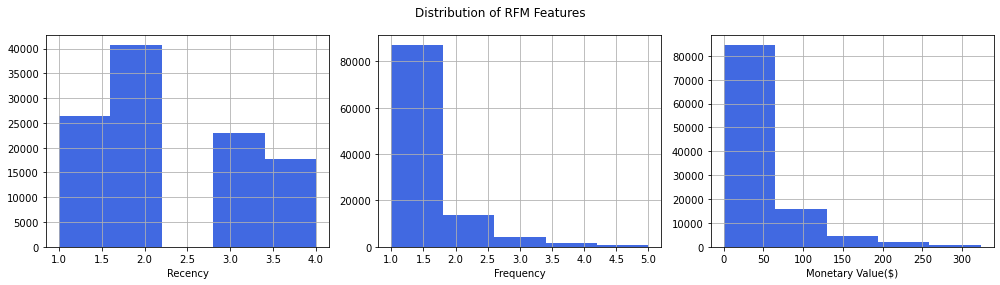

In [27]:
# plot the distribution of RFM
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
df_RFM.recency.hist(bins=5, color='royalblue')
plt.xlabel('Recency')

plt.subplot(1,3,2)
df_RFM.frequency.hist(bins=5, color='royalblue')
plt.xlabel('Frequency')

plt.subplot(1,3,3)
df_RFM.monetary.hist(bins=5, color='royalblue')
plt.xlabel('Monetary Value($)')
plt.suptitle('Distribution of RFM Features')
plt.tight_layout()
plt.show()

### KMeans Clustering using RFM

In [28]:
# standardize data
X = StandardScaler().fit_transform(df_RFM[['recency','frequency','monetary']])

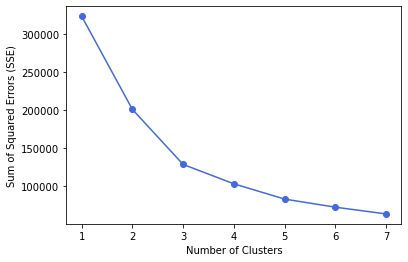

In [29]:
# find the optimize cluster size
sse=[]
for n in range(1,8):
    kmeans=KMeans(n_clusters=n)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1,8), sse, marker='o', color='royalblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

Based on the elbow technique, it is recommended to proceed with 3 clusters.

In [30]:
km=KMeans(n_clusters=3)
pre=km.fit_predict(X)
df_RFM['cluster']=pre

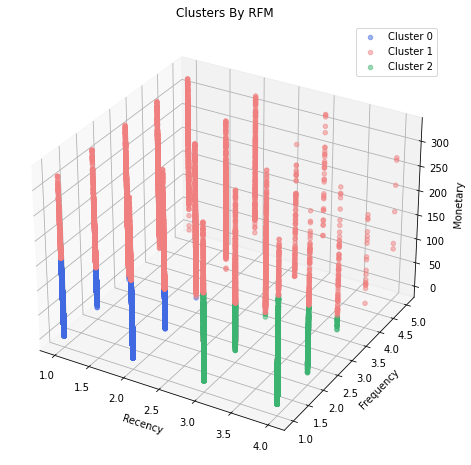

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
colors=['royalblue','lightcoral','mediumseagreen']

for cluster in [0,1,2]:
    cluster_df = df_RFM[df_RFM['cluster'] == cluster]
    ax.scatter(cluster_df['recency'], cluster_df['frequency'], cluster_df['monetary'], c=colors[cluster], 
               marker='o', alpha=0.5, label=f'Cluster {cluster}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Clusters By RFM')
ax.legend()
plt.show()

Due to the large size of Cluster 1, we plan to introduce an additional cluster to enhance the level of detail in the analysis.

In [32]:
km4=KMeans(n_clusters=4)
pre4=km4.fit_predict(X)
df_RFM['cluster4']=pre4

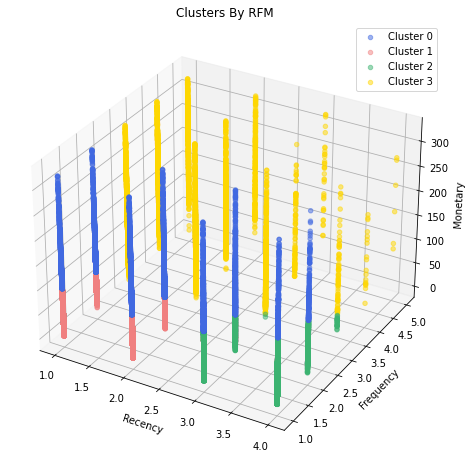

In [33]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
colors=['royalblue','lightcoral','mediumseagreen','gold']

for cluster in [0,1,2,3]:
    cluster_df = df_RFM[df_RFM['cluster4'] == cluster]
    ax.scatter(cluster_df['recency'], cluster_df['frequency'], cluster_df['monetary'], c=colors[cluster], 
               marker='o', alpha=0.5, label=f'Cluster {cluster}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Clusters By RFM')
ax.legend()
plt.show()

In [34]:
# find out the mean values of each cluster
c_mean=df_RFM.groupby('cluster4').agg({'recency':'mean','frequency':'mean','monetary':'mean'})
c_mean.monetary=round(c_mean.monetary,2)
c_mean

,recency,frequency,monetary
cluster4,,,
0,2.022687,1.569254,135.67
1,1.637118,1.109386,30.49
2,3.456692,1.059975,32.64
3,1.556831,3.495465,135.01


Renaming clusters according to their specific behaviors and features as follow:
- Cluster 0 : Potential High-Value Customers
- Cluster 1 : New Customers
- Cluster 2 : Dormant Customers
- Cluster 3 : Loyal Customers

In [35]:
c_mean = c_mean.rename(index={0:'Potential High-Value Customers',1:'New Customers',2:'Dormant Customers',3:'Loyal Customers'})
c_mean

,recency,frequency,monetary
cluster4,,,
Potential High-Value Customers,2.022687,1.569254,135.67
New Customers,1.637118,1.109386,30.49
Dormant Customers,3.456692,1.059975,32.64
Loyal Customers,1.556831,3.495465,135.01


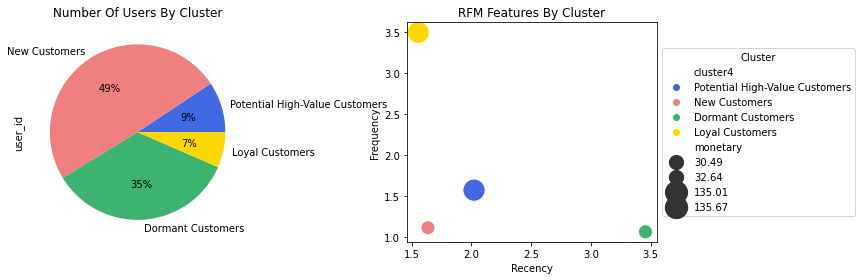

In [36]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
labels=['Potential High-Value Customers', 'New Customers', 'Dormant Customers', 'Loyal Customers']
df_RFM.groupby('cluster4').user_id.count().plot(kind='pie', labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Number Of Users By Cluster')

plt.subplot(1,2,2)
sns.scatterplot(data=c_mean, x='recency', y='frequency', size='monetary', hue='cluster4',
                palette=colors, sizes=[200,205,490,500])
legend=plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
legend.set_title('Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('RFM Features By Cluster')
plt.tight_layout()
plt.show()

###  Random Sampling and Pattern Observation for Clustering Validation

In [37]:
# combine the cluster data with the original dataframe to observe different trends among the clusters
c_label=df_RFM[['user_id','cluster4']]
cdf=df.merge(c_label)
cdf=cdf.rename(columns={'cluster4':'cluster'})
cdf.cluster=cdf.cluster.map({0:'Potential High-Value Customers',1:'New Customers',2:'Dormant Customers',3:'Loyal Customers'})
cdf.head()

,event_time,event_type,price,user_id,user_session,month,cluster
0,2019-10-01 00:00:00,cart,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct,Dormant Customers
1,2019-10-01 00:00:03,cart,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct,Dormant Customers
2,2019-10-01 00:00:07,cart,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct,Dormant Customers
3,2019-10-01 00:02:32,cart,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct,Dormant Customers
4,2019-10-01 00:02:40,cart,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct,Dormant Customers


In [38]:
cdf['user_id'] = cdf['user_id'].astype(str)

In [39]:
cdf_sales=cdf[cdf.event_type=='purchase']

In [40]:
# cart abandonment rate by cluster
purchase = cdf_sales.groupby('cluster').user_id.count()
cart = cdf[df.event_type == 'cart'].groupby('cluster').user_id.count()
ab = pd.concat([purchase, cart], axis=1, keys=["purchase #", "cart #"])
ab['cart abandonment rate']=1-(ab['purchase #']/ab["cart #"])
ab

C:\Users\acer\AppData\Local\Temp\ipykernel_20600\2874521994.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cart = cdf[df.event_type == 'cart'].groupby('cluster').user_id.count()


,purchase #,cart #,cart abandonment rate
cluster,,,
Dormant Customers,263269,696492,0.622007
Loyal Customers,215803,639022,0.662292
New Customers,347034,949400,0.634470
Potential High-Value Customers,237911,549115,0.566737


In [41]:
# calculate average order value by cluster
avo = cdf_sales.groupby('cluster').agg({'price':'sum','user_session':'nunique'})
avo['average order value($) per session'] = round(avo.price/avo.user_session, 2)
avo

,price,user_session,average order value($) per session
cluster,,,
Dormant Customers,1218889.34,39589,30.79
Loyal Customers,952634.14,24664,38.62
New Customers,1624216.85,59107,27.48
Potential High-Value Customers,1363457.74,15771,86.45


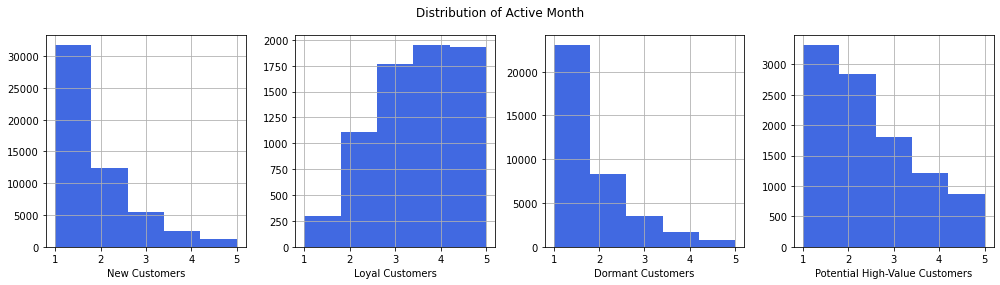

In [42]:
plt.figure(figsize=(14,4))
plt.subplot(1,4,1)
cdf[cdf.cluster=='New Customers'].groupby('user_id').month.nunique().hist(bins=5, color='royalblue')
plt.xlabel('New Customers')

plt.subplot(1,4,2)
cdf[cdf.cluster=='Loyal Customers'].groupby('user_id').month.nunique().hist(bins=5, color='royalblue')
plt.xlabel('Loyal Customers')

plt.subplot(1,4,3)
cdf[cdf.cluster=='Dormant Customers'].groupby('user_id').month.nunique().hist(bins=5, color='royalblue')
plt.xlabel('Dormant Customers')

plt.subplot(1,4,4)
cdf[cdf.cluster=='Potential High-Value Customers'].groupby('user_id').month.nunique().hist(bins=5, color='royalblue')
plt.xlabel('Potential High-Value Customers')
plt.suptitle('Distribution of Active Month')
plt.tight_layout()
plt.show()

Take random 10 samples from each cluster to observe their behavior records.

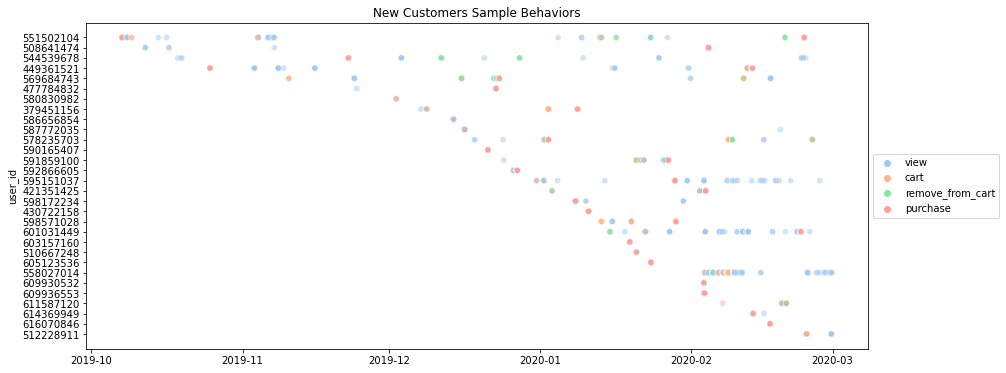

In [46]:
new_ids=cdf.loc[cdf['cluster']=='New Customers','user_id'].unique()
new_10=pd.Series(new_ids).sample(n=30, random_state=42)
new=cdf[cdf['user_id'].isin(new_10)]
plt.figure(figsize=(14,6))
hue_order=['view', 'cart', 'remove_from_cart', 'purchase']
sns.scatterplot(data=new, x='event_time', y='user_id', hue='event_type', hue_order=hue_order, palette='pastel', alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.xlabel('')
plt.title('New Customers Sample Behaviors')
plt.show()

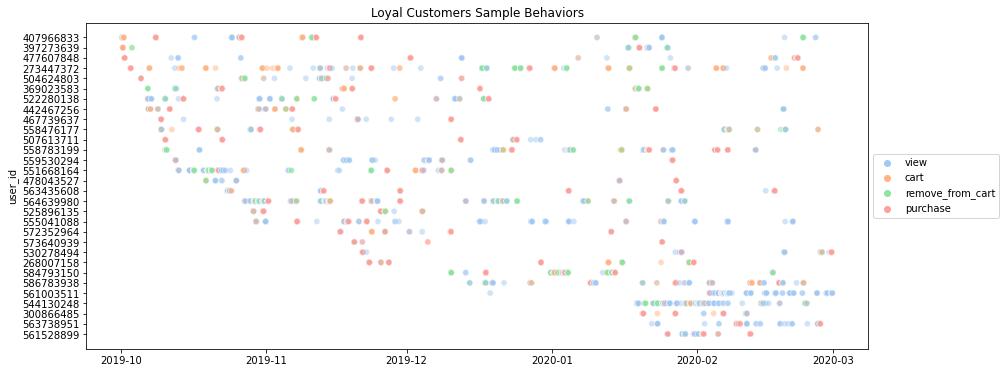

In [47]:
act_ids=cdf.loc[cdf['cluster']=='Loyal Customers','user_id'].unique()
act_10=pd.Series(act_ids).sample(n=30, random_state=42)
act=cdf[cdf['user_id'].isin(act_10)]
plt.figure(figsize=(14,6))
sns.scatterplot(data=act, x='event_time', y='user_id', hue='event_type', hue_order=hue_order, palette='pastel', alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.xlabel('')
plt.title('Loyal Customers Sample Behaviors')
plt.show()

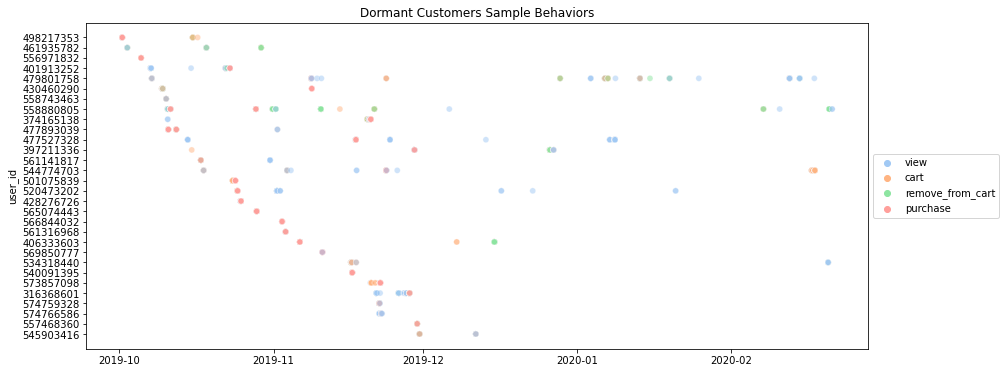

In [48]:
dor_ids=cdf.loc[cdf['cluster']=='Dormant Customers','user_id'].unique()
dor_10=pd.Series(dor_ids).sample(n=30, random_state=42)
dor=cdf[cdf['user_id'].isin(dor_10)]
plt.figure(figsize=(14,6))
sns.scatterplot(data=dor, x='event_time', y='user_id', hue='event_type', hue_order=hue_order, palette='pastel', alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.xlabel('')
plt.title('Dormant Customers Sample Behaviors')
plt.show()

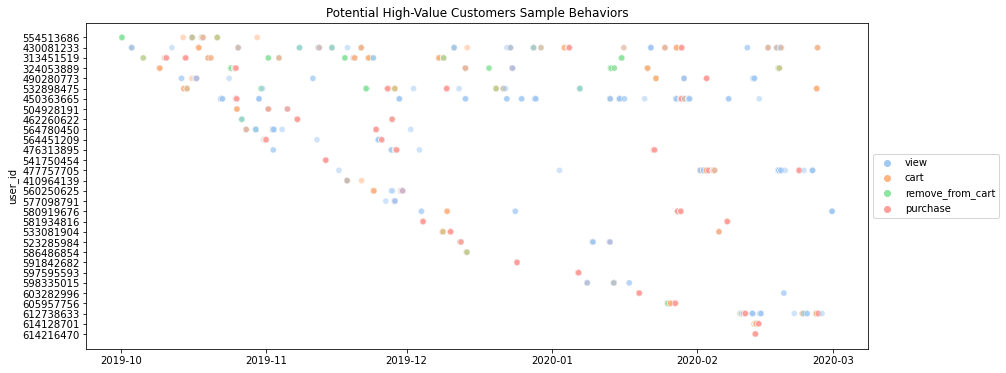

In [49]:
pot_ids=cdf.loc[cdf['cluster']=='Potential High-Value Customers','user_id'].unique()
pot_10=pd.Series(pot_ids).sample(n=30, random_state=42)
pot=cdf[cdf['user_id'].isin(pot_10)]
plt.figure(figsize=(14,6))
sns.scatterplot(data=pot, x='event_time', y='user_id', hue='event_type', hue_order=hue_order, palette='pastel', alpha=0.5)
plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.xlabel('')
plt.title('Potential High-Value Customers Sample Behaviors')
plt.show()

### Insights
1. Dormant customers represent approximately one-third of the total customer base. Upon analyzing the sample records and observing a mean frequency of 1.06, it is evident that most dormant customers are one-time purchasers. This highlights a significant challenge for the business in terms of customer retention.

2. Loyal customers exhibit a high purchase frequency and generate substantial sales, making them a valuable segment for any business. However, it is noteworthy that their cart abandonment rate is the highest among all clusters. This could be attributed to a higher number of products being added to the cart compared to other clusters.

3. New customers account for nearly half of all customers, which is a positive sign if the business is performing well. However, based on the observed traffic and sales trends, it is evident that the business struggles to retain a significant portion of new customers.

4. Potential high-value customers represent another profitable and stable cluster that requires attention. They exhibit the lowest cart abandonment rate and the highest average order values. It is essential to monitor the frequency of this cluster over a longer period to determine whether their shopping habits remain consistent or if their interest starts to decline.

### Recommendations
Based on the insights, here are some tailored recommendations:

1. Conduct a customer survey: It is recommended to conduct a customer survey targeting dormant customers. Offer incentives such as free samples or discounts to encourage their participation. Through the survey, gather insights into their reasons for not shopping with the business anymore. This information can help identify areas of improvement and develop targeted strategies to win back their engagement.

2. Re-engage new customers: Send limited-time discount offers or exclusive promotions to new customers who have been inactive for a certain period, such as 20 days. By providing enticing incentives, the business can encourage these customers to make repeat purchases and increase their level of engagement.

3. Nurture potential high-value customers: Pay special attention to potential high-value customers who show promising purchase behavior. Implement personalized marketing strategies, such as tailored product recommendations or exclusive perks, to maintain their interest and loyalty. Monitor their shopping habits over time to ensure they remain engaged and satisfied with their experience.

By implementing these recommendations, the business can actively address customer retention issues, re-engage dormant customers, cultivate loyalty among new customers, and maximize the potential of high-value customers.

[Click here to see the project documentation](https://github.com/Manyu-Ku/Ecomm_Customer_Segmentation_Analysis/blob/main/README.md)